In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import h5py
from math import pi

from analysis.config import birds, h5_path_dict, pickle_dir
from analysis.ExpData import ExpData
from analysis.utils import popln_overlap, get_fr

# Collect population patterns 
Visit patterns are (visits, neurs, frames) size

### Parameters

In [69]:
window = int(20*5)
fr_smoothing_window = int(20*0.25)
episode_significance = False
l2_normalization = True

### Data formatting

In [70]:
population_patterns = {}
for key in h5_path_dict.keys():
    for fil in range(len(h5_path_dict[key])):
        fil_string = h5_path_dict[key][fil].as_posix()
        f = h5py.File(fil_string, 'r')
        exp_data = ExpData(f)
        population_patterns[fil_string] = {}
        cr_pokes = exp_data.event_pokes[
            np.logical_or(exp_data.cache_event, exp_data.retriev_event)
            ]
        cr_visits = np.array([
            np.arange(p - window, p + window + 1) for p in cr_pokes
            ])
        cr_visits[cr_visits < 0] = -1
        cr_visits[cr_visits >= exp_data.num_frames] = -1
        fr = get_fr(exp_data.spikes, fr_smoothing_window)
        if l2_normalization:
            scaling = np.square(np.linalg.norm(fr, axis=1))
            fr /= scaling[:, None]
        cr_patterns = np.zeros(
            (cr_visits.shape[0], exp_data.num_neurs, window*2 + 1)
            )
        for i, visit in enumerate(cr_visits):
            cr_pattern = fr[:, visit]
            cr_pattern[:, visit == -1] = np.nan
            cr_patterns[i] = cr_pattern
        population_patterns[fil_string]['cr_patterns'] = cr_patterns

/home/chingf/anaconda3/envs/analysis-env/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


# Plot Heatmap of Relative Activation Times

In [75]:
all_overlap_matrices = []
for fil_string in population_patterns.keys():
    f = h5py.File(fil_string, 'r')
    exp_data = ExpData(f)
    cr_patterns = population_patterns[fil_string]['cr_patterns']
    cache_indices = np.argwhere(exp_data.cache_event).squeeze()
    retriev_indices = np.argwhere(exp_data.retriev_event).squeeze()

    for cache_index in cache_indices:
        c_site = exp_data.event_sites[cache_index]
        cache_pattern_mat = cr_patterns[cache_index]
        for retriev_index in retriev_indices:
            if retriev_index <= cache_index: continue
            r_site = exp_data.event_sites[retriev_index]
            if r_site != c_site: continue
            retriev_pattern_mat = cr_patterns[retriev_index]
            overlap_matrix = []
            for retriev_pattern in retriev_pattern_mat.T:
                cache_retriev_overlap = popln_overlap(
                    cache_pattern_mat, retriev_pattern
                    )
                overlap_matrix.append(cache_retriev_overlap)
            overlap_matrix = np.array(overlap_matrix)
            all_overlap_matrices.append(overlap_matrix)
all_overlap_matrices = np.array(all_overlap_matrices)
all_overlap_matrices = np.nanmean(all_overlap_matrices, axis=0)

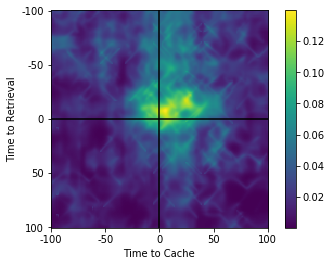

In [76]:
window_size = all_overlap_matrices.shape[0]
window_ticks = np.arange(0, window_size, window_size//4)
plt.imshow(all_overlap_matrices)
plt.yticks(window_ticks, window_ticks-window_size//2)
plt.xticks(window_ticks, window_ticks-window_size//2)
plt.axhline(window_size//2, color="black")
plt.axvline(window_size//2, color="black")
plt.ylabel("Time to Retrieval")
plt.xlabel("Time to Cache")
plt.colorbar()
plt.show()